<a href="https://colab.research.google.com/github/SvitlanaSm/Online-store-sales-analytics/blob/main/Portfolio_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Аутентифікація
auth.authenticate_user()

# Створення клієнта для BigQuery
client = bigquery.Client(project="data-analytics-mate")

# SQL-запит
query = """
SELECT s.date,
       s.ga_session_id,
       sp.continent,
       sp.country,
       sp.device,
       sp.browser,
       sp.mobile_model_name,
       sp.operating_system,
       sp.language,
       sp.medium,
       sp.channel,
       acs.account_id,
       a.is_verified,
       a.is_unsubscribed,
       p.category,
       p.name,
       p.price,
       p.short_description
FROM `data-analytics-mate.DA.session` s
join `data-analytics-mate.DA.session_params` sp
on s.ga_session_id = sp.ga_session_id
left join `data-analytics-mate.DA.account_session` acs
on s.ga_session_id = acs.ga_session_id
left join `data-analytics-mate.DA.account` a
on acs.account_id = a.id
left join `data-analytics-mate.DA.order` o
on s.ga_session_id = o.ga_session_id
left join `data-analytics-mate.DA.product` p
on o.item_id = p.item_id

"""

# Виконання запиту
query_job = client.query(query)
results = query_job.result()

# Перетворення результатів на DataFrame
df = results.to_dataframe()

# Виведення результату
df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

In [ ]:
# Number of unique session
len(pd.unique(df['ga_session_id']))

349545

In [ ]:
# Find period of analysis
print(f"First date: {min(df['date'])}")
print(f"Last date: {max(df['date'])}")

First date: 2020-11-01
Last date: 2021-01-31


##Опис датасету:
* Загальна кількість колонок - **18**.  
* Кількість колонок числового типу - **5**: ga_session_id, account_id, is_verified, is_unsubscribed, price.  
* Кількість колонок категоріального типу - **12**: continent, country, device, browser, mobile_model_name, operating_system, language, medium, channel, category, name, short_description.  
* Кількість колонок типу datetime - **1**.  
* Кількість унікальних сесій - **349 545**.  
* Розглядається період часу **від 2020-11-01 до 2021-01-31**.  
* **Є пропущені значення** з інформації про акаунти (account_id, is_verified, is_unsubscribed, category) та продукти ( name, price, short_description), так як зареєстрованих користувачів небагато, але нас цікавлять усі замовлення та усі сесії, навіть якщо користувач не зареєструвався на сайті.







In [ ]:
# Top-3 continent by sales
grouped_by_continent = df.groupby("continent")["price"].sum()
sorted_by_continent = grouped_by_continent.sort_values(ascending=False).nlargest(3)
print(f"Топ-3 континента за загальною сумою продажів:")
print(sorted_by_continent)

Топ-3 континента за загальною сумою продажів:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64


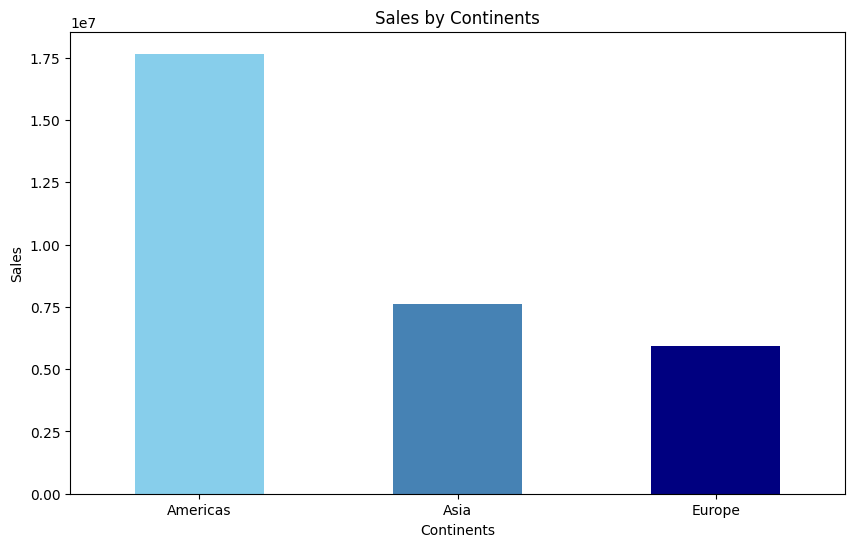

In [ ]:
#Create a bar plot "Sales by Continents"
sorted_by_continent.plot(kind='bar', figsize=(10,6), title="Sales by Continents", color=['skyblue','steelblue','navy'])

plt.xlabel("Continents")
plt.ylabel("Sales")
plt.xticks(rotation=0)

plt.show()

По графіку видно що **абсолютним лідером з продажів в нас є Америка.** Друге місце займає Азія, але більш ніж вдічі меншими продажами порівняно з Америкою. Третє місце Європа.

In [ ]:
# Top-3 continent by orders
orders = df[df["name"].notnull()]
grouped_by_continent_orders = orders.groupby("continent")["name"].count()
sorted_by_continent_orders = grouped_by_continent_orders.sort_values(ascending=False).nlargest(3)
print(f"Топ-3 континента за кількістю замовлень:")
print(sorted_by_continent_orders)

Топ-3 континента за кількістю замовлень:
continent
Americas    18553
Asia         7950
Europe       6261
Name: name, dtype: int64


In [ ]:
len(orders)

33538

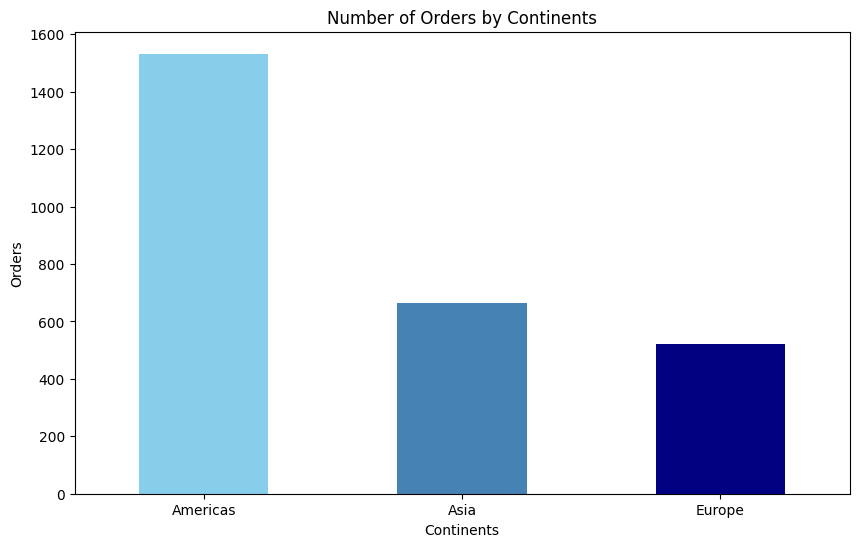

In [ ]:
#Create a bar plot "Orders by Continents"
sorted_by_continent_orders.plot(kind='bar', figsize=(10,6), title="Number of Oreders by Continents", color=['skyblue','steelblue','navy'])

plt.xlabel("Continents")
plt.ylabel("Orders")
plt.xticks(rotation=0)

plt.show()

Аналогічно з попереднім аналізом продажів, найбільша кількість замовлень є в Америці, після якої йдуть Азія та Європа, але вже зі значно меншими числами.

In [ ]:
#Top-5 countries by sales
grouped_by_country = df.groupby("country")["price"].sum()
sorted_by_country = grouped_by_country.sort_values(ascending=False).nlargest(5)
print(f"Топ-5 країн за загальною сумою продажів:")
print(sorted_by_country)

Топ-5 країн за загальною сумою продажів:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64


In [ ]:
#Top-5 countries by orders

grouped_by_country_orders = orders.groupby("country")["name"].count()
sorted_by_country_orders = grouped_by_country_orders.sort_values(ascending=False).nlargest(5)
print(f"Топ-5 країн за кількістю замовлень:")
print(sorted_by_country_orders)

Топ-5 країн за кількістю замовлень:
country
United States     1207
India              246
Canada             207
United Kingdom      88
France              56
Name: name, dtype: int64


Так, як по континетах переважає Америка, то абсолютно логічним є результат **1 місця по країнам - Сполучені Штати.** Зі значно меншими, але подібними результатами далі йдуть Індія та Канада. Та закривають рейтинг топ-5 країн - Велика Британія та Франція.

In [ ]:
#Top-10 categories by sales
grouped_by_category = df.groupby("category")["price"].sum()
sorted_by_category = grouped_by_category.sort_values(ascending=False).nlargest(10)
print(f"Топ-10 категорій товарів за загальною сумою продажів:")
print(sorted_by_category)

Топ-10 категорій товарів за загальною сумою продажів:
category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: price, dtype: float64


In [ ]:
#Top-3 languages by sales
grouped_by_language = df.groupby("language")["price"].sum()
sorted_by_language = grouped_by_language.sort_values(ascending=False).nlargest(3)
print(f"Топ-3 мови за загальною сумою продажів:")
print(sorted_by_language)

Топ-3 мови за загальною сумою продажів:
language
en-us    14715870.2
en-gb     2181314.3
zh        1053040.6
Name: price, dtype: float64


In [ ]:
#Top-3 languages by oders
grouped_by_language_orders = orders.groupby("language")["name"].count()
sorted_by_language_orders = grouped_by_language_orders.sort_values(ascending=False).nlargest(3)
print(f"Топ-3 мови за кількістю замовлень:")
print(sorted_by_language_orders)

Топ-3 мови за кількістю замовлень:
language
en-us    1242
en-gb     214
zh        107
Name: name, dtype: int64


Так як основною країною з продажів є Сполучені Штати, а основним континентом - Америка, тому маємо найпопулярнішу мову - **англійську (us)**.

In [ ]:
#Top-10 categories by sales in United States (top-1 country by sales)
df_top_country = df[df["country"] == "United States"]
top_categories = df_top_country.groupby("category")["price"].sum().sort_values(ascending=False).nlargest(10)
print(f"Топ-10 категорій товарів у країні з найбільшими продажами (United States):")
print(top_categories)

Топ-10 категорій товарів у країні з найбільшими продажами (United States):
category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0
Name: price, dtype: float64


<ipython-input-18-1f25a956d294>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


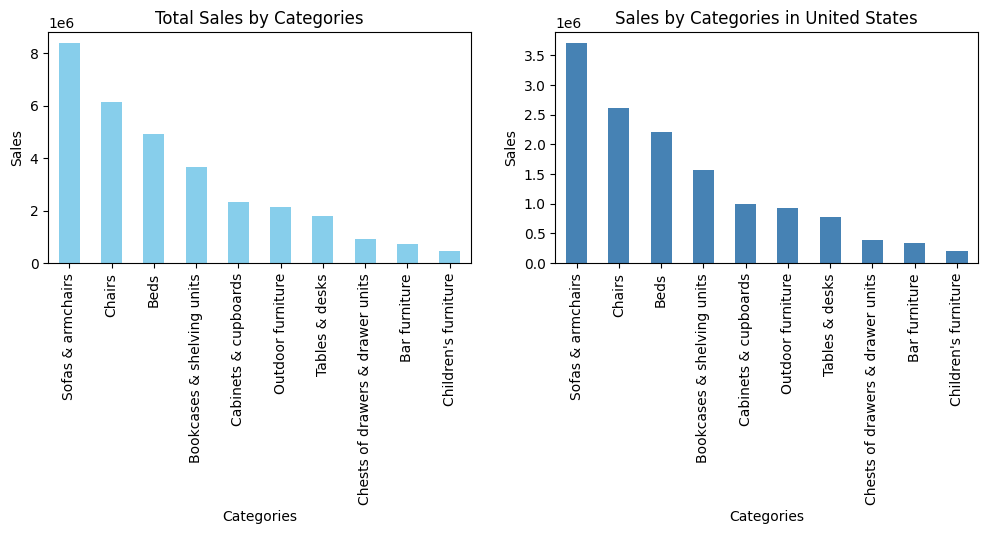

In [ ]:
# Create a figure with 1 rows and 2 columns of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# First subplot - Bar plot of Total Sales by Categories
sorted_by_category.plot(kind="bar", ax=ax[0], color="skyblue")
ax[0].set_title("Total Sales by Categories")  # Title of the subplot
ax[0].set_xlabel("Categories")  # X-axis label
ax[0].set_ylabel("Sales")  # Y-axis label

# Second subplot - Bar plot of Sales by Categories in United States
top_categories.plot(kind="bar", ax=ax[1], color="steelblue")
ax[1].set_title("Sales by Categories in United States")  # Title of the subplot
ax[1].set_xlabel("Categories")  # X-axis label
ax[1].set_ylabel("Sales")  # Y-axis label

plt.tight_layout()
plt.show()

Топ-10 категорій товарів у країні з найбільшими продажами (Сполучені Штати) не відрізняється від топ-10 загальних категорій товарів.

In [ ]:
#Percentage of registered users who verified
registered_users = df[df["account_id"].notnull()]
verified_users = registered_users[registered_users["is_verified"] == 1]
perc_verified = len(verified_users) / len(registered_users) *100
print(f"Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: {round(perc_verified,2)}")

Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: 71.7


In [ ]:
#Percentage of registered users who unsubscribed
unsubscribed_users = registered_users[registered_users["is_unsubscribed"] == 1]
perc_unsubscribed = len(unsubscribed_users) / len(registered_users) *100
print(f"Відсоток зареєстрованих користувачів, які відписалися від розсилки: {round(perc_unsubscribed,2)}")

Відсоток зареєстрованих користувачів, які відписалися від розсилки: 16.94


In [ ]:
#Sales by subscribe
df_unsubscribed = df.groupby("is_unsubscribed")["price"].sum()
df_unsubscribed = df_unsubscribed.rename({0: "subscribed", 1: "unsubscribed"})
print(f"Продажі підписаних та відписаних від розсилки: {df_unsubscribed}")

Продажі підписаних та відписаних від розсилки: is_unsubscribed
subscribed      2150796.9
unsubscribed     431721.6
Name: price, dtype: float64


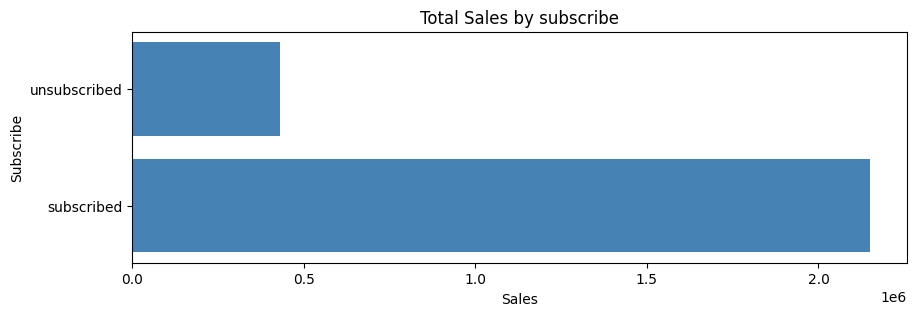

In [ ]:
# Create horizontal bar plot with total sales by subscribe
plt.figure(figsize=(10, 3))
bars = plt.barh(df_unsubscribed.index, df_unsubscribed.values, color="steelblue")
plt.title("Total Sales by subscribe")
plt.xlabel("Sales")
plt.ylabel("Subscribe")

plt.show()

Помімні значно більші продажу у підписаних на розсилку користувачів.

##Аналіз динаміки продажів

In [ ]:
#Total sales by date
groupped_by_date = df.groupby("date")["price"].sum()
print(groupped_by_date)

date
2020-11-01    244292.5
2020-11-02    355506.8
2020-11-03    498979.6
2020-11-04    339187.1
2020-11-05    391276.6
                ...   
2021-01-27    286340.7
2021-01-28         0.0
2021-01-29         0.0
2021-01-30         0.0
2021-01-31         0.0
Name: price, Length: 92, dtype: float64


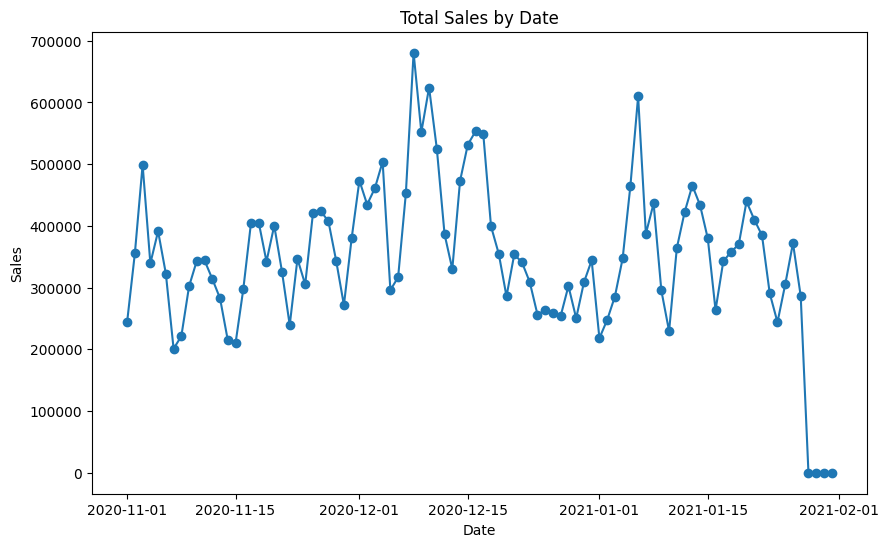

In [ ]:
#Create line plot with Total Sales by Date
plt.figure(figsize=(10, 6))
plt.plot(groupped_by_date.index, groupped_by_date.values, marker="o")
plt.title("Total Sales by Date")  # Title of the graph
plt.xlabel("Date")  # X-axis label
plt.ylabel("Sales")  # Y-axis label
plt.show()

Піки продажів орієнтовно 7-10 грудня та 7-10 січня. Після піків помітні різкі зниження продажів. У кінці періоду є нульові значення, можливо по причинні відсутності даних. Можлива тижнева сезонність, адже у проміжках по 15 днів видні суттєві коливання.

In [ ]:
#Sales on Top-3 continents by date
top_3_continent = df[df["continent"].isin(["Americas", "Asia", "Europe"])]
groupped_by_continent_date = top_3_continent.groupby(["continent","date"])["price"].sum().reset_index()
print(groupped_by_continent_date)

    continent        date     price
0    Americas  2020-11-01  132002.5
1    Americas  2020-11-02  193861.0
2    Americas  2020-11-03  294529.8
3    Americas  2020-11-04  200009.5
4    Americas  2020-11-05  182988.2
..        ...         ...       ...
271    Europe  2021-01-27   48156.1
272    Europe  2021-01-28       0.0
273    Europe  2021-01-29       0.0
274    Europe  2021-01-30       0.0
275    Europe  2021-01-31       0.0

[276 rows x 3 columns]


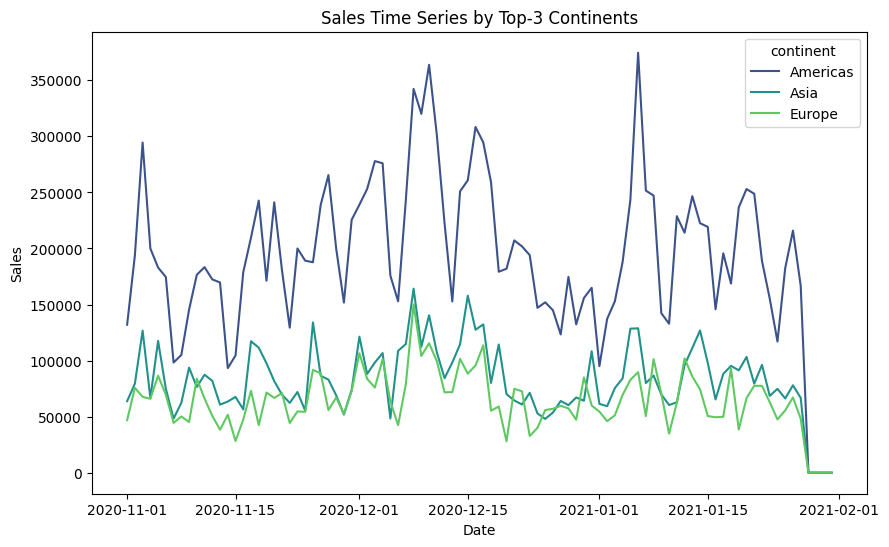

In [ ]:
#Create line plot with Sales Time Series by Top-3 Continents
plt.figure(figsize=(10, 6))
sns.lineplot(data=groupped_by_continent_date, x="date", y="price", hue="continent", palette = "viridis", errorbar=("ci", False))
plt.title("Sales Time Series by Top-3 Continents")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

Продажі по країнах коливаються майже одночасно, тільки різниця в тому, що Америка має значну перевна у продажах.

In [ ]:
df["device"].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

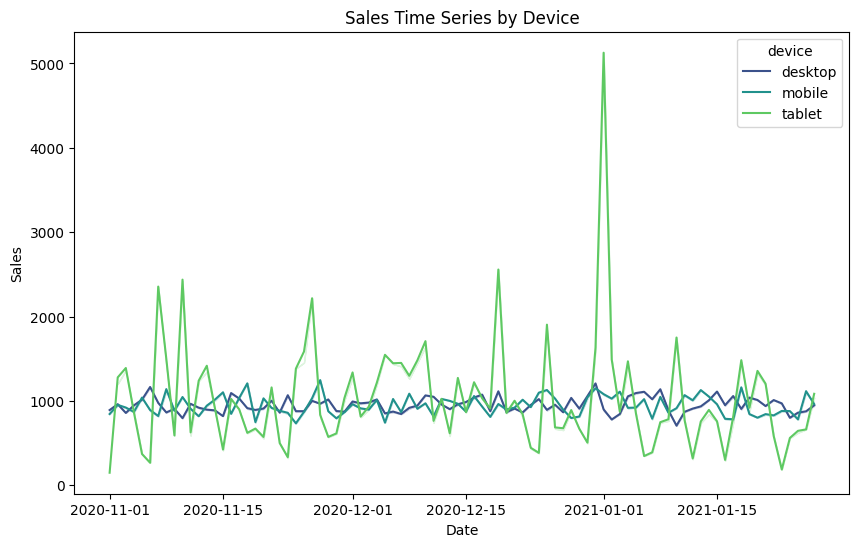

In [ ]:
#Create line plot with Sales Time Series by Device
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="date", y="price", hue="device", palette = "viridis", errorbar=("ci", False))
plt.title("Sales Time Series by Device")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

По мобільних та комп'ютерах досить стабільна силуація, в той час як продажі з планшетів досить сильно коливаються. Тому можливо варто це дослідити краще.

##Зведені таблиці

In [ ]:
# Creating a pivot table to sum sales by channel and device
df_clean = df.dropna(subset=["channel", "device", "ga_session_id"])
pivot_table = pd.pivot_table(df_clean, values="ga_session_id", index="channel", columns="device", aggfunc="count", dropna=True)
print(pivot_table)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


In [ ]:
# Creating a pivot table to sum sales by top-10 categories and top-5 countries
top_countries = sorted_by_country.index.tolist()
top_categories = sorted_by_category.index.tolist()
df_5country_10category = df[df["country"].isin(top_countries) & df["category"].isin(top_categories)]
pivot_table_5country_10category = pd.pivot_table(df_5country_10category, values="price", index="category", columns="country", aggfunc="sum")
print(pivot_table_5country_10category)

country                             Canada    France     India  \
category                                                         
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
category                                                         
Bar furniture                            22103.0       330805.0  
Beds     

In [ ]:
# Creating a pivot table to sum sales by top-10 categories and top-3 continents
top_continent = sorted_by_continent.index.tolist()
top_categories = sorted_by_category.index.tolist()
df_3continent_10category = df[df["continent"].isin(top_continent) & df["category"].isin(top_categories)]
pivot_table_3continent_10category = pd.pivot_table(df_5country_10category, values="price", index="category", columns="continent", aggfunc="sum")
print(pivot_table_3continent_10category)

continent                          Americas      Asia    Europe
category                                                       
Bar furniture                      382529.0   57657.0   33302.0
Beds                              2567830.0  358319.5  250230.0
Bookcases & shelving units        1846588.8  364507.4  187817.6
Cabinets & cupboards              1176347.5  191888.0  130786.0
Chairs                            3037514.6  544309.2  322548.8
Chests of drawers & drawer units   454340.0   73111.0   58328.5
Children's furniture               237839.0   39177.0   27606.0
Outdoor furniture                 1114568.0  162289.4   97488.8
Sofas & armchairs                 4399572.0  788430.0  422547.0
Tables & desks                     910543.0  186157.5   91673.0


#Статистичний аналіз взаємозв’язків

###Взаємозв’язок між кількістю сесій та загальними продажами за кожну дату

In [ ]:
#Number of sessions and sales by date
grouped = df.groupby("date").agg({
    "price": "sum",
    "ga_session_id": "count"
})

print(grouped)

               price  ga_session_id
date                               
2020-11-01  244292.5           2576
2020-11-02  355506.8           3599
2020-11-03  498979.6           5173
2020-11-04  339187.1           4184
2020-11-05  391276.6           3743
...              ...            ...
2021-01-27  286340.7           4435
2021-01-28       0.0           4112
2021-01-29       0.0           3700
2021-01-30       0.0           2845
2021-01-31       0.0           2812

[92 rows x 2 columns]


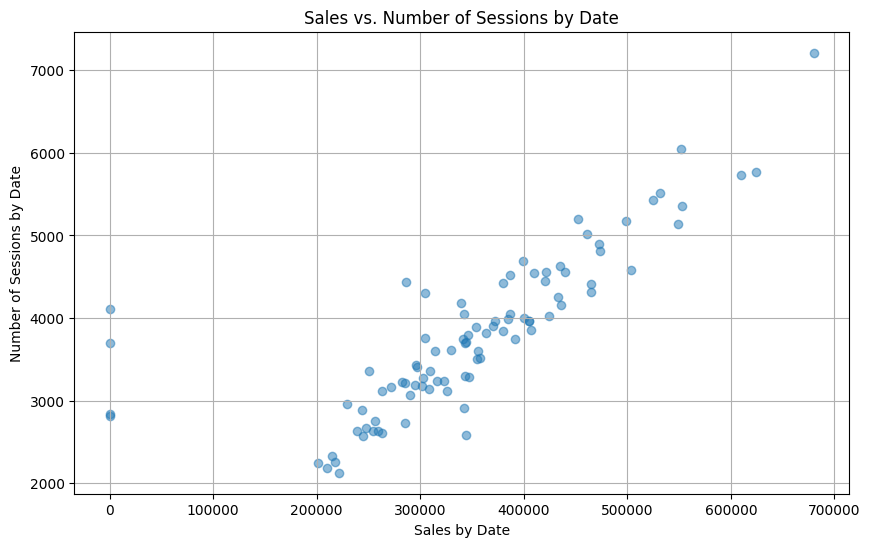

In [ ]:
#Create scatter plot with Sales vs. Number of Sessions by Date
plt.figure(figsize=(10, 6))
plt.scatter(grouped["price"], grouped["ga_session_id"], alpha=0.5)
plt.xlabel("Sales by Date")
plt.ylabel("Number of Sessions by Date")
plt.title("Sales vs. Number of Sessions by Date")
plt.grid(True)
plt.show()

По графіку достатньо чітко видно що дані мають сильну позитивну кореляцію.

In [ ]:
from scipy.stats import spearmanr

# Calculate p-value for Sales vs. Number of Sessions by Date
print(f"Test statistic and p-value: {spearmanr(grouped['price'], grouped['ga_session_id'])}")

# Calculate Pearson correlation for Sales vs. Number of Sessions by Date
spearman_corr = grouped["price"].corr(grouped["ga_session_id"], method="spearman")
print(f"Spearman Correlation: {spearman_corr}")


Test statistic and p-value: SignificanceResult(statistic=np.float64(0.865306217456368), pvalue=np.float64(9.755923586156684e-29))
Spearman Correlation: 0.865306217456368


Оскільки **p-value < 0.05**, взаємозв'язок між кількістю сесій та загальними продажами за кожну дату є статистично значущим. За величиною коефіцієнта кореляції, приблизно 0.865, робимо висновок, що змінні мають **сильний прямий зв'язок**.

###Чи корелюють між собою продажі на різних континентах? (топ-3 континенти)

In [ ]:
# Creating a pivot table to sum sales by date and top-3 continents
top_3_continent = df[df["continent"].isin(["Americas", "Asia", "Europe"])]
pivot_table_top_3_continent = pd.pivot_table(top_3_continent, values="price", index="date", columns="continent", aggfunc="sum")
print(pivot_table_top_3_continent)

continent   Americas      Asia   Europe
date                                   
2020-11-01  132002.5   63823.0  46908.0
2020-11-02  193861.0   79370.0  75710.8
2020-11-03  294529.8  126737.8  67692.0
2020-11-04  200009.5   66602.0  65915.0
2020-11-05  182988.2  117608.4  86540.0
...              ...       ...      ...
2021-01-27  166735.5   66783.1  48156.1
2021-01-28       0.0       0.0      0.0
2021-01-29       0.0       0.0      0.0
2021-01-30       0.0       0.0      0.0
2021-01-31       0.0       0.0      0.0

[92 rows x 3 columns]


In [ ]:
from scipy.stats import spearmanr

# Calculate p-value
print(f"Test statistic and p-value: {spearmanr(pivot_table_top_3_continent['Americas'], pivot_table_top_3_continent['Asia'])}")

# Calculate Pearson correlation
spearman_corr_am_as = pivot_table_top_3_continent["Americas"].corr(pivot_table_top_3_continent["Asia"], method="spearman")
print(f"Spearman Correlation: {spearman_corr_am_as}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.7099016615801969), pvalue=np.float64(2.3233796296203977e-15))
Spearman Correlation: 0.7099016615801969


In [ ]:
# Calculate p-value
print(f"Test statistic and p-value: {spearmanr(pivot_table_top_3_continent['Americas'], pivot_table_top_3_continent['Europe'])}")

# Calculate Pearson correlation
spearman_corr_am_eu = pivot_table_top_3_continent['Americas'].corr(pivot_table_top_3_continent['Europe'], method="spearman")
print(f"Spearman Correlation: {spearman_corr_am_eu}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.6725700545639509), pvalue=np.float64(2.1035588726455927e-13))
Spearman Correlation: 0.6725700545639509


In [ ]:
# Calculate p-value
print(f"Test statistic and p-value: {spearmanr(pivot_table_top_3_continent['Asia'], pivot_table_top_3_continent['Europe'])}")

# Calculate Pearson correlation
spearman_corr_as_eu = pivot_table_top_3_continent['Asia'].corr(pivot_table_top_3_continent['Europe'], method="spearman")
print(f"Spearman Correlation: {spearman_corr_as_eu}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.6571102685039614), pvalue=np.float64(1.1290947217450973e-12))
Spearman Correlation: 0.6571102685039614


Оскільки **p-value < 0.05**, взаємозв'язок між продажами на різних континентах є статистично значущим.  
 Величина коефіцієнта кореляції Спірмена між Америкою та Азією приблизно 0.710, робимо висновок, що змінні мають **сильний прямий зв'язок**.  
 Між Америкою та Європою, Азією та Європою коефіцієнти кореляції Спірмена 0.673 та 0.657 відповідно, тому ці континенти мають **помірний прямий зв'язок**.

#Статистичний аналіз відмінностей між групами

###Аналіз продажів за кожну дату зареєстрованих та незареєстрованих користувачів.

In [ ]:
groupped_registered = registered_users.groupby("date")["price"].sum()
print(groupped_registered)

date
2020-11-01    21547.0
2020-11-02    44956.8
2020-11-03    29150.5
2020-11-04    20982.2
2020-11-05    25334.6
               ...   
2021-01-23    16117.0
2021-01-24    20914.0
2021-01-25    34163.8
2021-01-26    27213.6
2021-01-27    14613.6
Name: price, Length: 88, dtype: float64


In [ ]:
unregistered_users = df[df["account_id"].isnull()]
groupped_unregistered = unregistered_users.groupby("date")["price"].sum()
print(groupped_unregistered)

date
2020-11-01    222745.5
2020-11-02    310550.0
2020-11-03    469829.1
2020-11-04    318204.9
2020-11-05    365942.0
                ...   
2021-01-27    271727.1
2021-01-28         0.0
2021-01-29         0.0
2021-01-30         0.0
2021-01-31         0.0
Name: price, Length: 92, dtype: float64


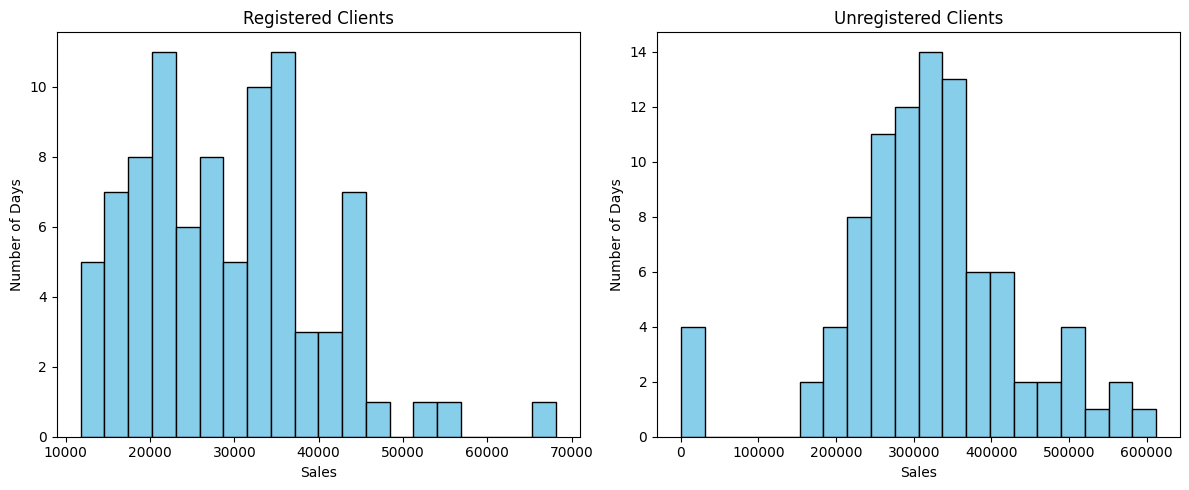

In [ ]:
# Plotting histograms
plt.figure(figsize=(12, 5))

# Registered Clients
plt.subplot(1, 2, 1)
plt.hist(groupped_registered, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Sales")
plt.ylabel("Number of Days")
plt.title("Registered Clients")

# Unregistered Clients
plt.subplot(1, 2, 2)
plt.hist(groupped_unregistered, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Sales")
plt.ylabel("Number of Days")
plt.title("Unregistered Clients")

plt.tight_layout()
plt.show()

Розподіл обох змінних не є нормальним, тому краще підійде **тест Манна-Уітні.**

In [ ]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(groupped_registered, groupped_unregistered)
print(f"U-statistic: {u_stat}, p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in time spent on pages A and B.")
else:
    print("There is no significant difference in time spent on pages A and B.")


U-statistic: 352.0, p-value: 3.8805185465235906e-26
There is a significant difference in time spent on pages A and B.


Оскільки **p-value < 0.05**, то різниця між продажами зареєстрованих користувачів та незареєстрованих є статистично значущою.

###Аналіз кількості сесій за різними каналами трафіку.

In [ ]:
pivot_table_device = pd.pivot_table(df, values="price", index="date", columns="device", aggfunc="sum")
print(pivot_table_device)

device       desktop    mobile   tablet
date                                   
2020-11-01  144445.0   99698.5    149.0
2020-11-02  206727.3  137269.5  11510.0
2020-11-03  304473.8  180602.8  13903.0
2020-11-04  212227.7  118324.4   8635.0
2020-11-05  249682.0  138256.0   3338.6
...              ...       ...      ...
2021-01-27  173453.5  102042.2  10845.0
2021-01-28       0.0       0.0      0.0
2021-01-29       0.0       0.0      0.0
2021-01-30       0.0       0.0      0.0
2021-01-31       0.0       0.0      0.0

[92 rows x 3 columns]


In [ ]:
from scipy.stats import kruskal

# Perform the Kruskal-Wallis test
stat, p_value = kruskal(pivot_table_device['desktop'], pivot_table_device['mobile'], pivot_table_device['tablet'])

print(f"Kruskal-Wallis statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in time spent on different pages.")
else:
    print("There is no significant difference in time spent on the pages.")


Kruskal-Wallis statistic: 178.03003203425416
P-value: 2.194167294023942e-39
There is a significant difference in time spent on different pages.


Оскільки **p-value < 0.05**, то різниця між продажами через різні девайси є статистично значущою.

###Чи корелюють між собою продажі за топ-5 категоріями товарів?

In [ ]:
top_5_categories = sorted_by_category.nlargest(5).index
print(top_5_categories)

Index(['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units',
       'Cabinets & cupboards'],
      dtype='object', name='category')


In [ ]:
# Creating a pivot table to sum sales by date and top-3 continents
df_top_5_categories = df[df["category"].isin(top_5_categories)]
pivot_table_top_5_categories = pd.pivot_table(df_top_5_categories, values="price", index="date", columns="category", aggfunc="sum")
print(pivot_table_top_5_categories)

category       Beds  Bookcases & shelving units  Cabinets & cupboards  \
date                                                                    
2020-11-01  14041.0                     36701.0               13591.5   
2020-11-02  79683.5                     40979.0               21623.0   
2020-11-03  66219.5                     64360.1               33555.5   
2020-11-04  48939.0                     35719.8               19266.0   
2020-11-05  23449.0                     40998.8               29235.0   
...             ...                         ...                   ...   
2021-01-23  37116.0                     29862.7               26068.0   
2021-01-24  23294.0                     25396.0               23664.5   
2021-01-25  47303.5                     25919.6               33028.0   
2021-01-26  69894.5                     39119.2               20218.0   
2021-01-27  43080.0                     33874.2               29739.0   

category     Chairs  Sofas & armchairs  
date     

In [ ]:
# Calculate p-value
print(f"Test statistic and p-value: {spearmanr(pivot_table_top_5_categories)}")

# Calculate Pearson correlation
spearman_corr_top_5_categories = pivot_table_top_5_categories.corr(method="spearman")
print(f"Spearman Correlation: {spearman_corr_top_5_categories}")

Test statistic and p-value: SignificanceResult(statistic=array([[1.        , 0.54274242, 0.44036843, 0.53494065, 0.52171463],
       [0.54274242, 1.        , 0.52870628, 0.63675108, 0.62560318],
       [0.44036843, 0.52870628, 1.        , 0.52682188, 0.63120355],
       [0.53494065, 0.63675108, 0.52682188, 1.        , 0.58331866],
       [0.52171463, 0.62560318, 0.63120355, 0.58331866, 1.        ]]), pvalue=array([[0.00000000e+00, 4.69083172e-08, 1.75878304e-05, 7.91341555e-08,
        1.86436772e-07],
       [4.69083172e-08, 0.00000000e+00, 1.19061296e-07, 2.58543758e-11,
        7.18899090e-11],
       [1.75878304e-05, 1.19061296e-07, 0.00000000e+00, 1.34491526e-07,
        4.32290827e-11],
       [7.91341555e-08, 2.58543758e-11, 1.34491526e-07, 0.00000000e+00,
        2.46282006e-09],
       [1.86436772e-07, 7.18899090e-11, 4.32290827e-11, 2.46282006e-09,
        0.00000000e+00]]))
Spearman Correlation: category                        Beds  Bookcases & shelving units  \
category    

Оскільки **p-value < 0.05**, то різниця між продажами за топ-5 категоріями товарів є статистично значущою.

###Чи відрізняється статистично доля сесій з органічним трафіком у Європі та Америці?

In [ ]:
organic_europe = df[(df["continent"] == "Europe") & (df["channel"] == "Organic Search")]
groupped_organic_europe = organic_europe.groupby(["channel", "continent"])["ga_session_id"].count()
print(groupped_organic_europe)

channel         continent
Organic Search  Europe       23195
Name: ga_session_id, dtype: Int64


In [ ]:
total_europe = df[(df["continent"] == "Europe")]
groupped_total_europe = total_europe.groupby("continent")["ga_session_id"].count()
print(groupped_total_europe)

continent
Europe    65135
Name: ga_session_id, dtype: Int64


In [ ]:
organic_americas = df[(df["continent"] == "Americas") & (df["channel"] == "Organic Search")]
groupped_organic_americas = organic_americas.groupby(["channel", "continent"])["ga_session_id"].count()
print(groupped_organic_americas)

channel         continent
Organic Search  Americas     68671
Name: ga_session_id, dtype: Int64


In [ ]:
total_americas = df[(df["continent"] == "Americas")]
groupped_total_americas = total_americas.groupby("continent")["ga_session_id"].count()
print(groupped_total_americas)

continent
Americas    193179
Name: ga_session_id, dtype: Int64


In [ ]:
import statsmodels.api as sm

# Perform z-test for two proportions
z_stat, p_value = sm.stats.proportions_ztest([groupped_organic_europe, groupped_organic_americas], [groupped_total_europe, groupped_total_americas])

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between versions A and B.")
else:
    print("No statistically significant difference between versions A and B.")

Z-statistic: [0.28951413]
P-value: [0.77218797]
No statistically significant difference between versions A and B.


У цьому випадку **p-value > 0.05**, тож немає статистично значущої різниці між долями сесій з органічним трафіком у Європі та Америці.

Tableau:  
* [Dashboard #1](https://public.tableau.com/app/profile/svitlana.smashna/viz/Salesanalysisofonlinestore/Salesanalysisofonlinestore)  
* [Dashboard #2](https://public.tableau.com/app/profile/svitlana.smashna/viz/Salesanalysisofonlinestore2_0/Salesanalysisofonlinestore2_0)